In [1]:
import os
import sys
import cv2
import numpy as np

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import seaborn as sns
from PIL import Image

from skimage.measure import block_reduce
from skimage.transform import rescale
from skimage.registration import phase_cross_correlation

from scipy.ndimage import shift as nd_shift
from scipy.ndimage import center_of_mass, rotate
from scipy.optimize import nnls

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import trange
from tqdm import tqdm

# repo_url = 'https://github.com/AustinHouston/SciFiReaders.git'
# !git clone {repo_url}

sys.path.insert(0, './SciFiReaders/')
from SciFiReaders import MRCReader

import pyTEMlib.file_tools as ft

%matplotlib ipympl

### Path names:

It's very useful to keep track of the .emd file that is recorded with the .mrc file

The .mrc files don't record some very important metadata (like pixel size - want a scalebar??)

In [13]:
path = '/Users/austin/Desktop/sample_data/Gold_bulk/'
image_path = '0001 - Nano STEM HAADF Diffraction.emd'
haadf_4D = '0002 - Nano STEM HAADF Diffraction.emd'
cbed_path = 'Velox-fab5f1ae4a524cc9af0e3954c2b0043d.mrc'


### Load the image

atomic resolution

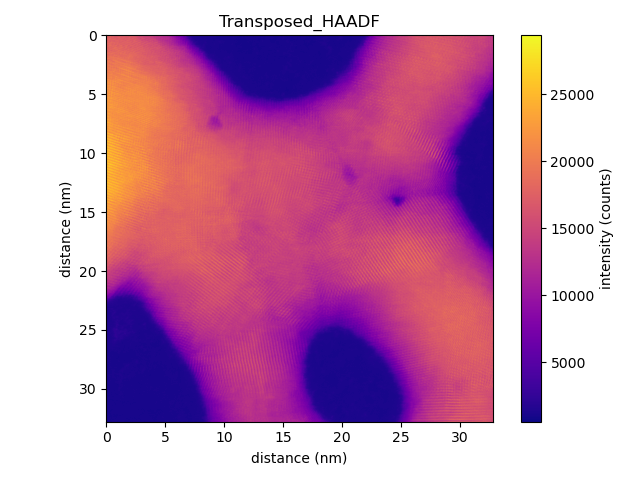

In [10]:
dset = ft.open_file(path + image_path)
image = dset['Channel_000']

view = image.T.plot(cmap='plasma')

### Load the image taken at the same time as the 4D STEM dataset

These are very useful to keep up with - take notes when you're on the microscope

ex: 

EMD : MRC folder

0002 : 20260204_082735

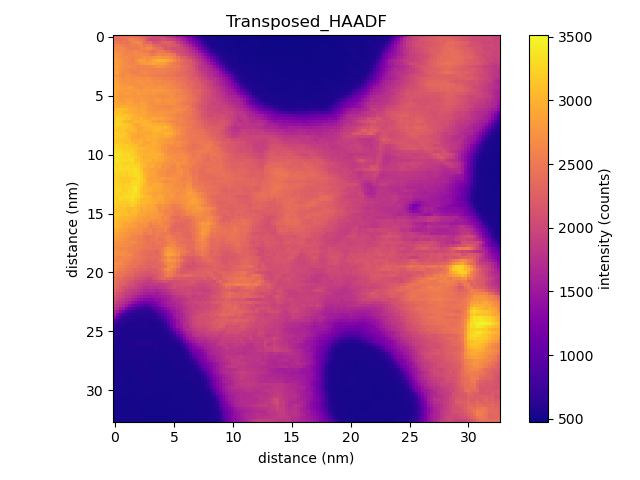

In [11]:
dset = ft.open_file(path + haadf_4D)
image = dset['Channel_000']

view = image.T.plot(cmap='plasma')

### Load 4D-STEM data

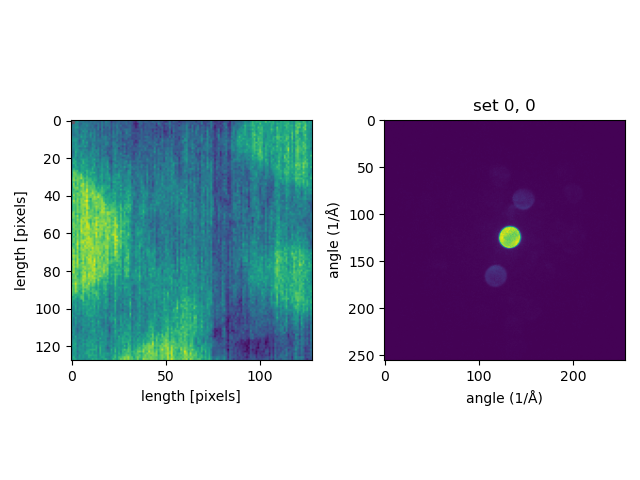

In [14]:
# Initialize
reader = MRCReader(path + cbed_path)

# Read in 4D data
dset = reader.read(handedness='right')
data = dset['Channel_000']

view = data.plot()

### Binning

for this example, we are going to bin the data to DRASTICALLY reduce computation time

I recomend binning until you tune the params, then go back and do a high-fidelity run

In [100]:
# Bin the data in last two dims
data_array = np.array(data)
binned_data = block_reduce(data_array, block_size=(2, 2, 4, 4), func=np.mean)
# Normalize the data (last 2 dims)
binned_data = binned_data / (np.sum(binned_data, axis=(-2, -1), keepdims=True) + 1e-10)

### Pixel sizes (very important for pubications):

In [101]:
pixel_size = image.x.slope
recip_pixel_size = data.u.slope

print(f'Real space pixel size: {pixel_size} nm')
print(f'Reciprocal pixel size: {recip_pixel_size} A^-1')
# yes, it is annoying that the units are different...I'll work on it

Real space pixel size: 0.2562034593235577 nm
Reciprocal pixel size: 0.015809424 A^-1


### Shift the zero-disks onto the center of the camera

We'll have to do this differently than for the 2D material case.

There, 99% of electrons stay in the zero-beam and there is basically no kinematic diffraction (so we can just find the center of mass)

Here, all bets are off.  we have to find the center disk in each image

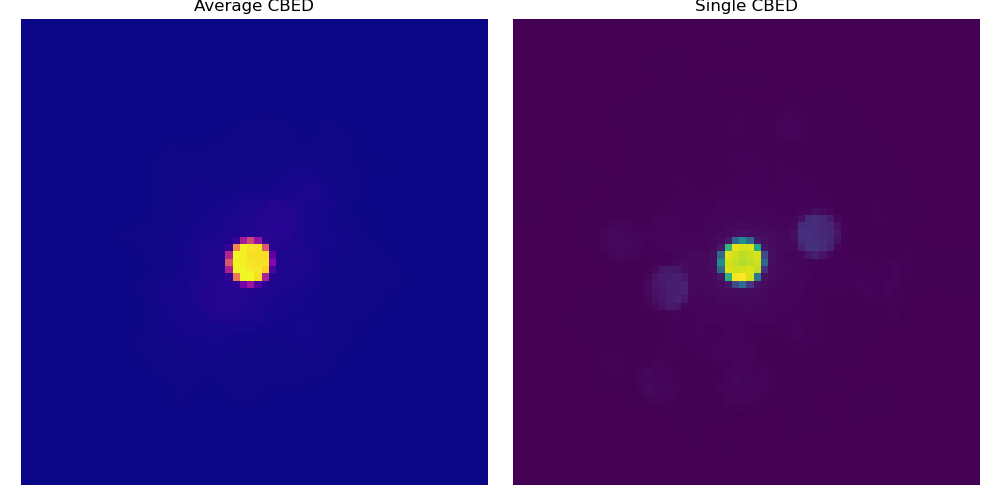

In [102]:
average_cbed = np.mean(binned_data, axis=(0,1))
average_cbed -= average_cbed.min()
average_cbed /= average_cbed.max()

fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize = (10,5))
ax[0].imshow(average_cbed.T, cmap='plasma')
ax[0].set_title('Average CBED')
ax[1].imshow(binned_data[0,0].T, cmap = 'viridis')
ax[1].set_title('Single CBED')

for a in ax:
    a.axis('off')
fig.tight_layout()

in the above image, our average zero-disk seems to be the same size as our single zero-disk.

let's use the average zero-disk to make a cross-correlation template

(you may have to do it a different way, if your average is not nice)


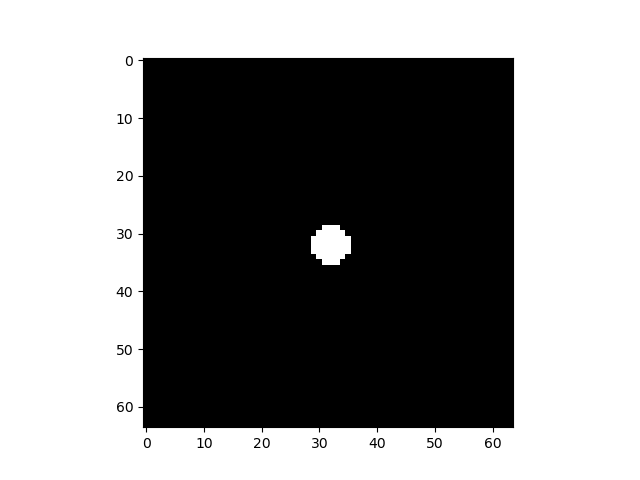

In [103]:
threshold = 0.1
binary_cbed = average_cbed > threshold

# shift com to center
com = center_of_mass(binary_cbed)
shift = np.array(binary_cbed.shape)/2 - np.array(com)
binary_cbed = nd_shift(binary_cbed, shift, order=0)


plt.figure()
plt.imshow(binary_cbed.T, cmap='gray')

### Draw a cirlce over the zero-beam

It's very bright, it's going to throw off all anaysis - but rest in peace

we already aligned all of the zero-beams.  thus we can assume there's no information lost!

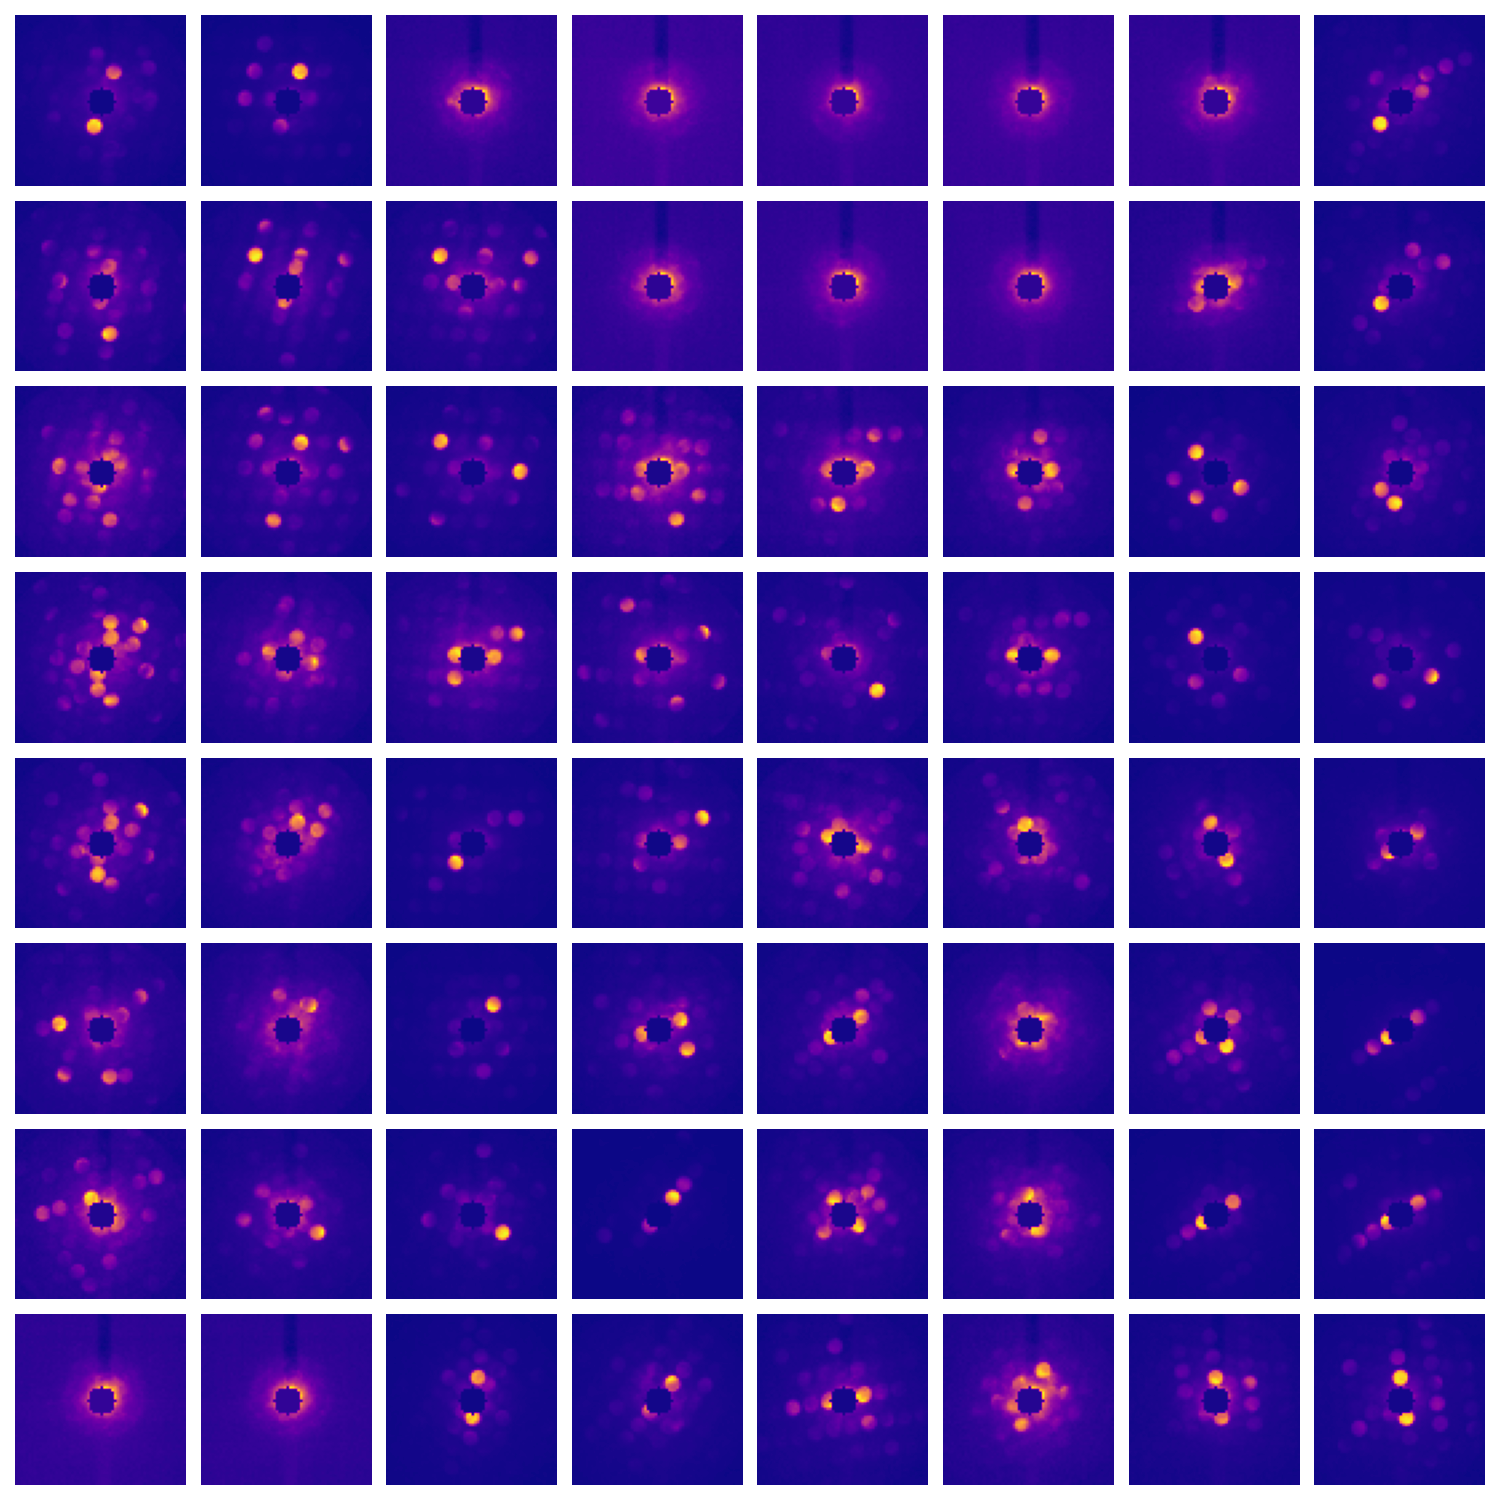

In [139]:
# you may have to change this:
r = 5

# Create a circular mask
diameter = 2 * r + 1
yy, xx = np.ogrid[:diameter, :diameter]
circle_mask = (xx - r)**2 + (yy - r)**2 <= r**2

# Apply the mask to zero out the center of each pattern
masked_data = binned_data.copy()
n_batches, n_channels, h, w = masked_data.shape
cy, cx = h // 2, w // 2  # assuming each pattern is centered

for b in range(n_batches):
    for c in range(n_channels):
        y_start, y_end = cy - r, cy + r + 1
        x_start, x_end = cx - r, cx + r + 1
        # Bounds check (optional, if dimensions vary)
        if 0 <= y_start and y_end <= h and 0 <= x_start and x_end <= w:
            masked_data[b, c, y_start:y_end, x_start:x_end][circle_mask] = 0
masked_data -= masked_data.min()
masked_data /= masked_data.max()

# visualize
fig, ax = plt.subplots(8,8, sharex=True, sharey=True, figsize=(15,15))
for xi in range(8):
    for yi in range(8):
        ax[xi,yi].imshow(masked_data[7*xi,7*yi], cmap='plasma')#, vmin=0.05, vmax=0.18)
        ax[xi,yi].axis('off')
fig.tight_layout()

### Edge crops

You'll notice the dark edges where the haadf cuts off the beam past some angle.

no need to do computations on these zero-information regions

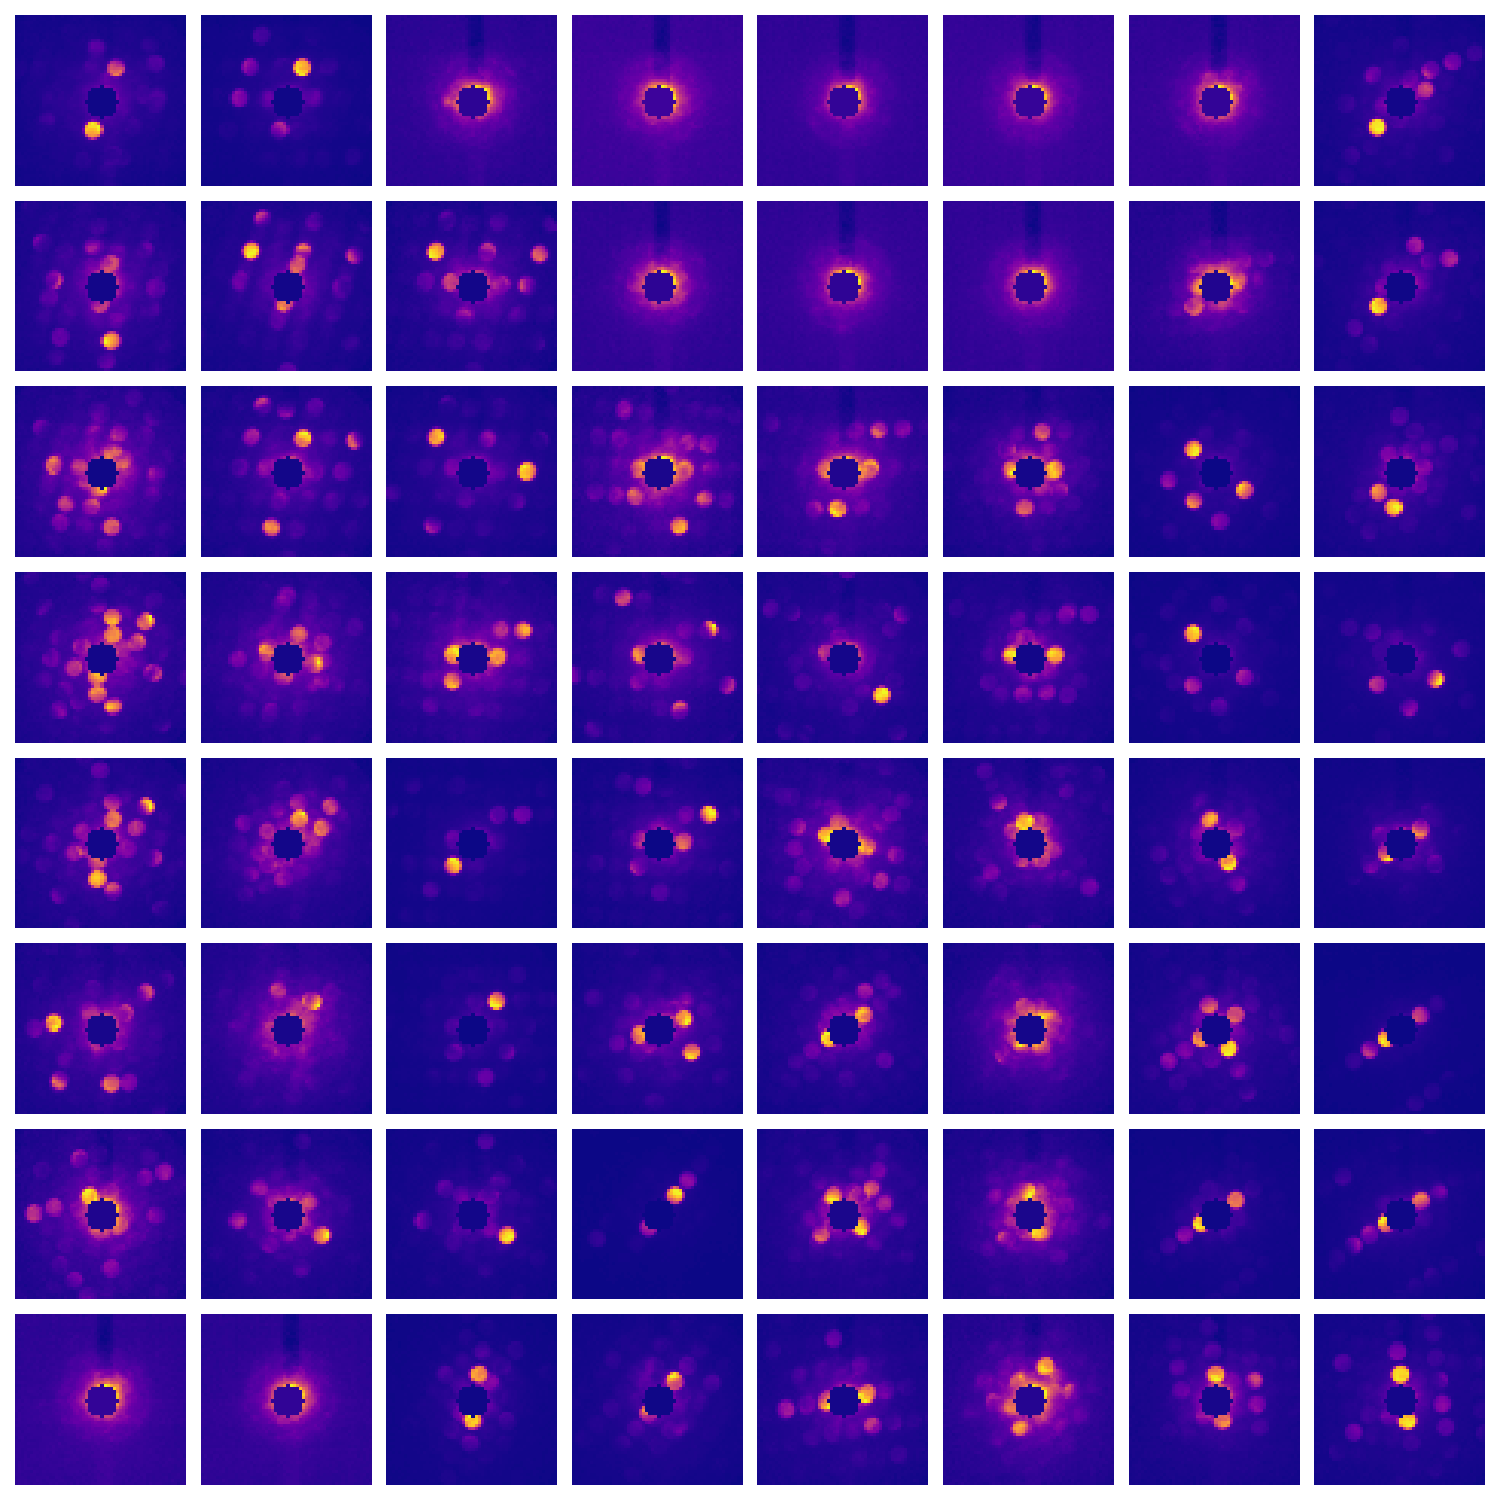

In [140]:
edge_crop = 4
norm_data = masked_data[:,:,edge_crop:-edge_crop, edge_crop:-edge_crop]

# visualize
fig, ax = plt.subplots(8,8, sharex=True, sharey=True, figsize=(15,15))
for xi in range(8):
    for yi in range(8):
        ax[xi,yi].imshow(norm_data[7*xi,7*yi], cmap='plasma')#, vmin=0.05, vmax=0.18)
        ax[xi,yi].axis('off')
fig.tight_layout()

In [141]:
norm_data_shape = norm_data.shape
norm_data_shape

(64, 64, 56, 56)

### NMF - should we use it?

Non-negative Matrix Factorization (NMF)

We find the 8 best components that describe the data

Then, we reconstruct the data using only these components


I we have more than 8 grains, we would be LOSING DATA!!!

So, don't do the cleaning/reconstruction step

Reconstruction error: 25.1441


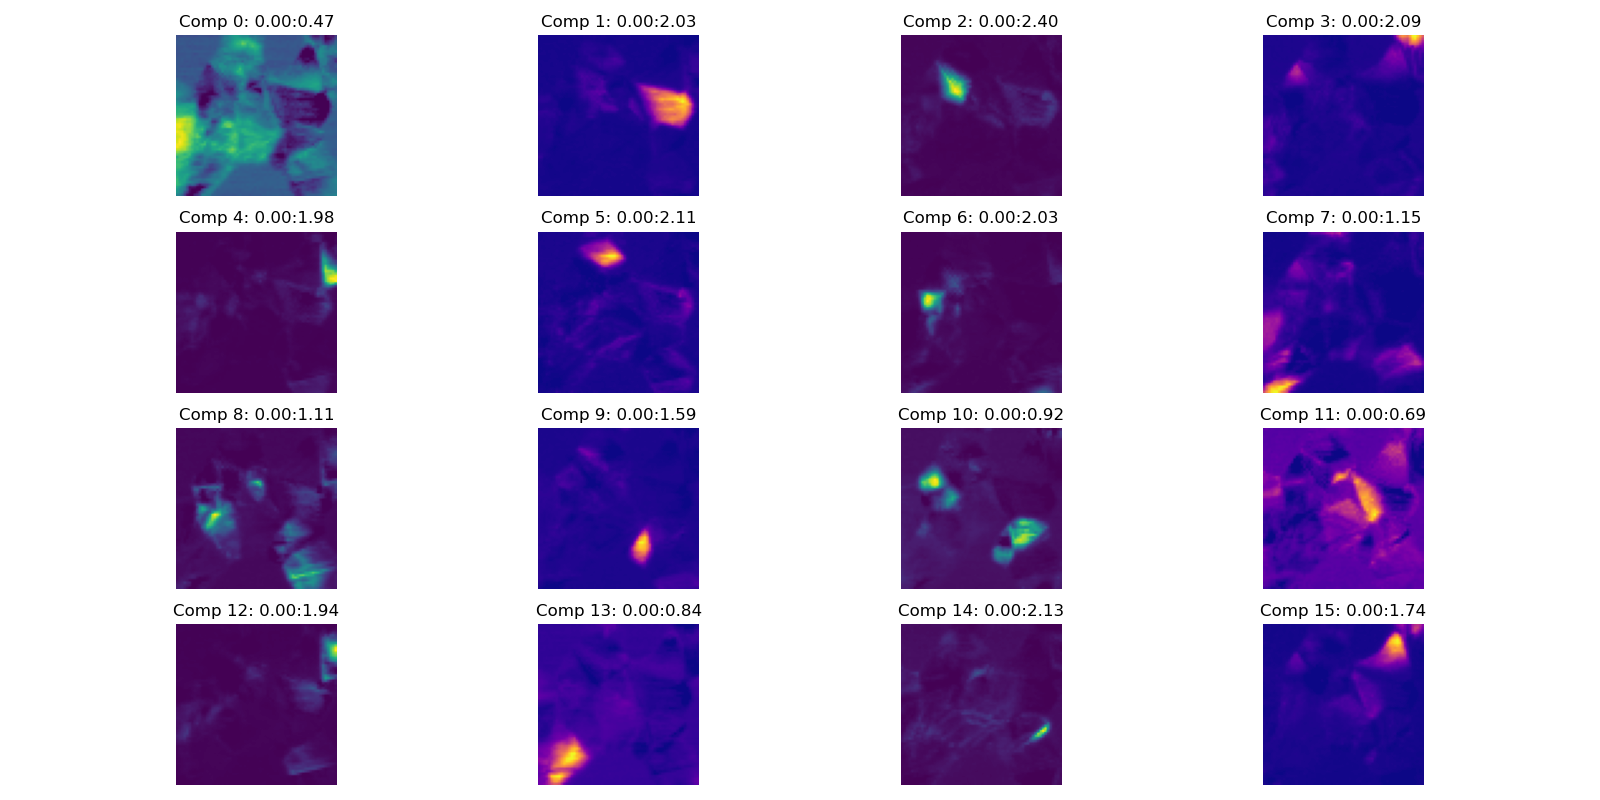

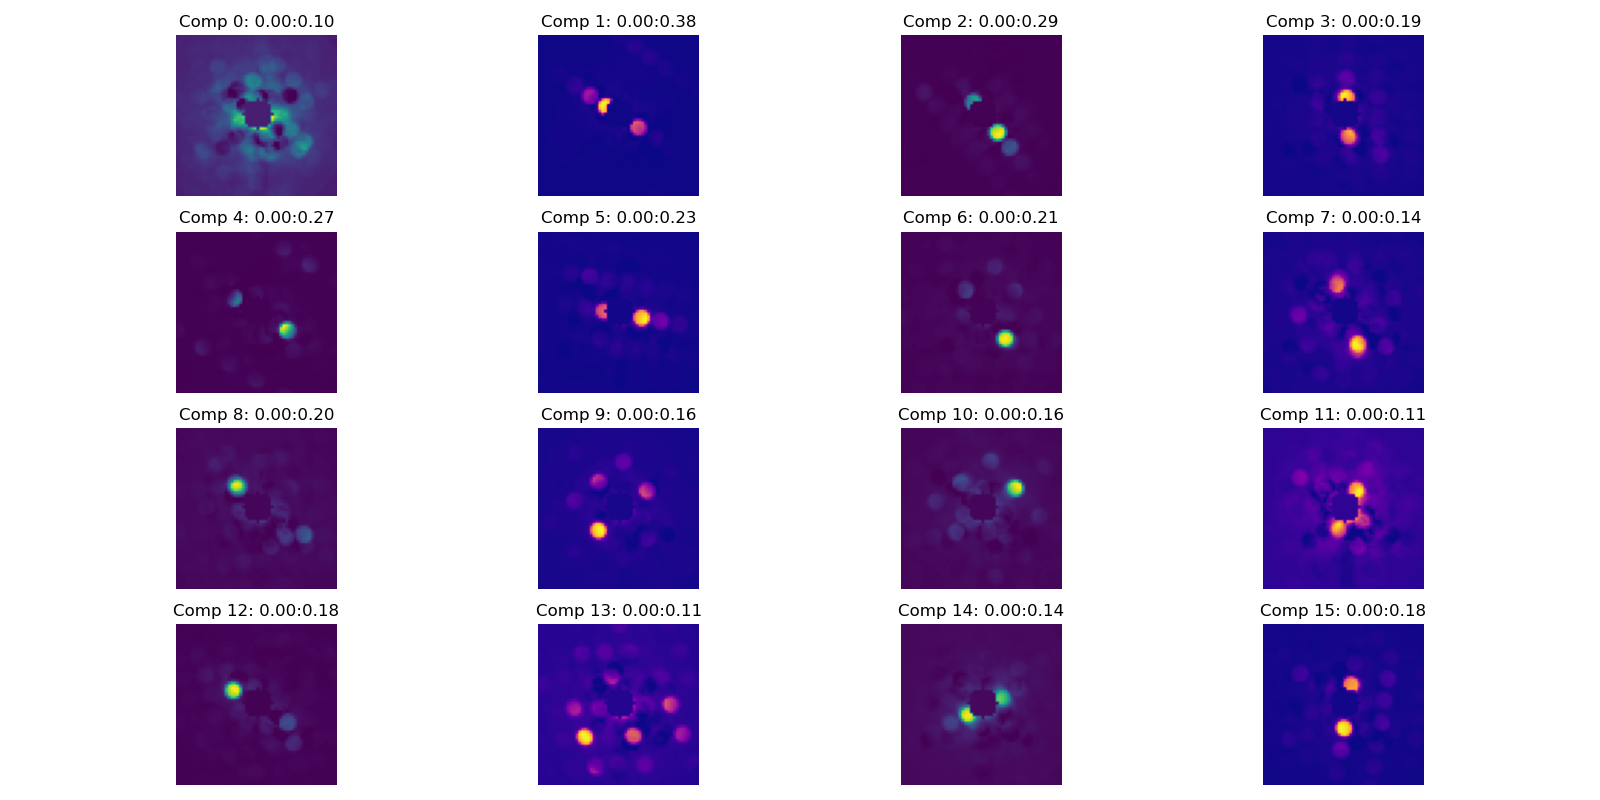

In [144]:
norm_data_flat = norm_data.reshape(-1, norm_data.shape[-2] * norm_data.shape[-1])
norm_data_flat = np.nan_to_num(norm_data_flat, nan=0.0)

n_components = 16
nmf = NMF(n_components=n_components, init='nndsvd', random_state=42, max_iter=2000, alpha_W=0.0001, alpha_H=0.01)
W = nmf.fit_transform(norm_data_flat)  # shape: (num_valid_pixels, n_components)
H = nmf.components_                 # shape: (n_components, 1024)

W_reshaped = W.reshape(norm_data.shape[0], norm_data.shape[1], n_components)
H_reshaped = H.reshape(n_components, norm_data.shape[-2], norm_data.shape[-1])
print(f"Reconstruction error: {nmf.reconstruction_err_:.4f}")


# Visualize real-space activations (W)
cmaps = ['viridis', 'plasma'] * 8  # repeating pattern of colormaps
fig, ax = plt.subplots(4, 4, figsize=(16, 8))
ax = ax.ravel()
for i in range(n_components):
    ax[i].imshow(image, cmap='grey')
    ax[i].imshow(W_reshaped[:, :, i], cmap=cmaps[i], origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'Comp {i}: {np.nanmin(W_reshaped[:,:,i]):.2f}:{np.nanmax(W_reshaped[:,:,i]):.2f}')

plt.tight_layout()
# Visualize component patterns (H)
fig, ax = plt.subplots(4, 4, figsize=(16, 8))
ax = ax.ravel()
for i in range(n_components):
    ax[i].imshow(H_reshaped[i], cmap=cmaps[i], origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'Comp {i}: {H_reshaped[i].min():.2f}:{H_reshaped[i].max():.2f}')
plt.tight_layout()


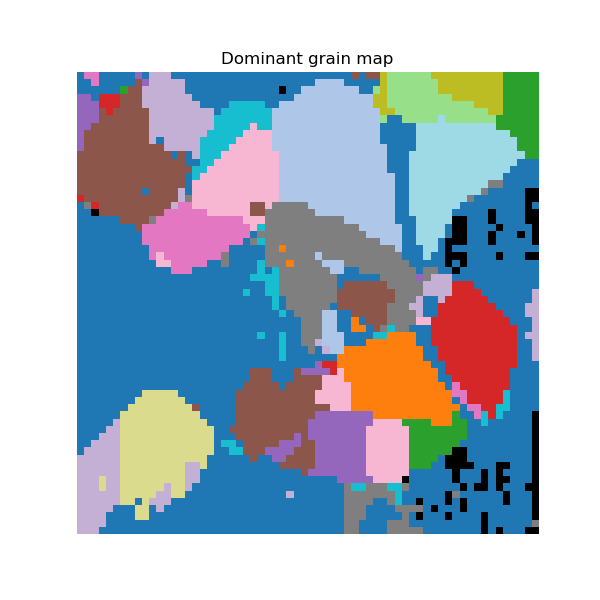

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- dominant component per pixel ---
dominant = np.argmax(W_reshaped, axis=2)          # (Nx, Ny)
strength = np.max(W_reshaped, axis=2)

# optional: confidence (how dominant is the winner?)
sorted_W = np.sort(W_reshaped, axis=2)
confidence = sorted_W[:, :, -1] / (sorted_W[:, :, -2] + 1e-8)

# mask weak pixels
min_strength = 0.05 * strength.max()
grain_map = np.where(strength > min_strength, dominant, -1)

# --- colormap ---
colors = plt.cm.tab20(np.linspace(0, 1, n_components))
colors = np.vstack([[0, 0, 0, 1], colors])   # black for background
grain_cmap = ListedColormap(colors)

# shift labels by +1 for background
grain_map_plot = grain_map + 1

plt.figure(figsize=(6, 6))
plt.imshow(grain_map_plot.T, cmap=grain_cmap, origin='lower')
plt.title("Dominant grain map")
plt.axis('off')
plt.show()

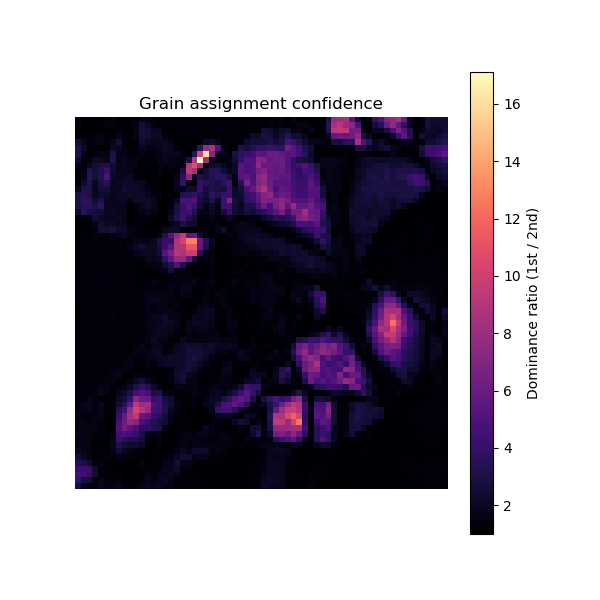

In [148]:
plt.figure(figsize=(6, 6))
plt.imshow(confidence.T, cmap='magma', origin='lower')
plt.colorbar(label="Dominance ratio (1st / 2nd)")
plt.title("Grain assignment confidence")
plt.axis('off')
plt.show()

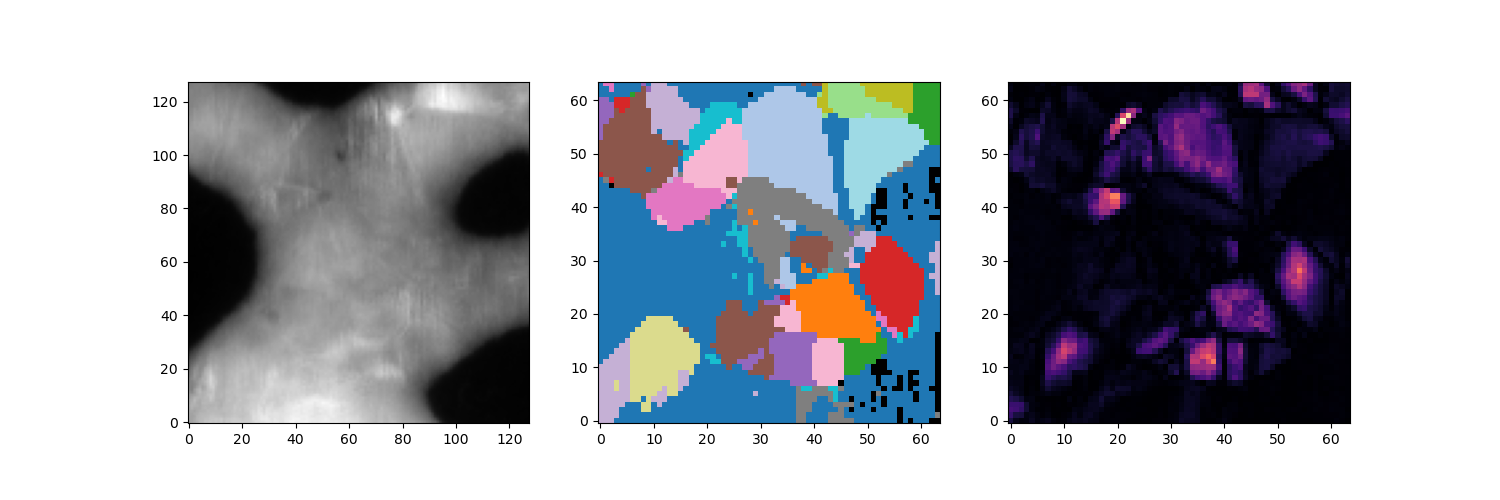

In [153]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].imshow(image.T, cmap='gray', origin='lower')

ax[1].imshow(grain_map_plot.T, cmap=grain_cmap, origin='lower')

ax[2].imshow(confidence.T, cmap='magma', origin='lower')

there are still some dark areas here, let's do it with more components:

Reconstruction error: 24.0367


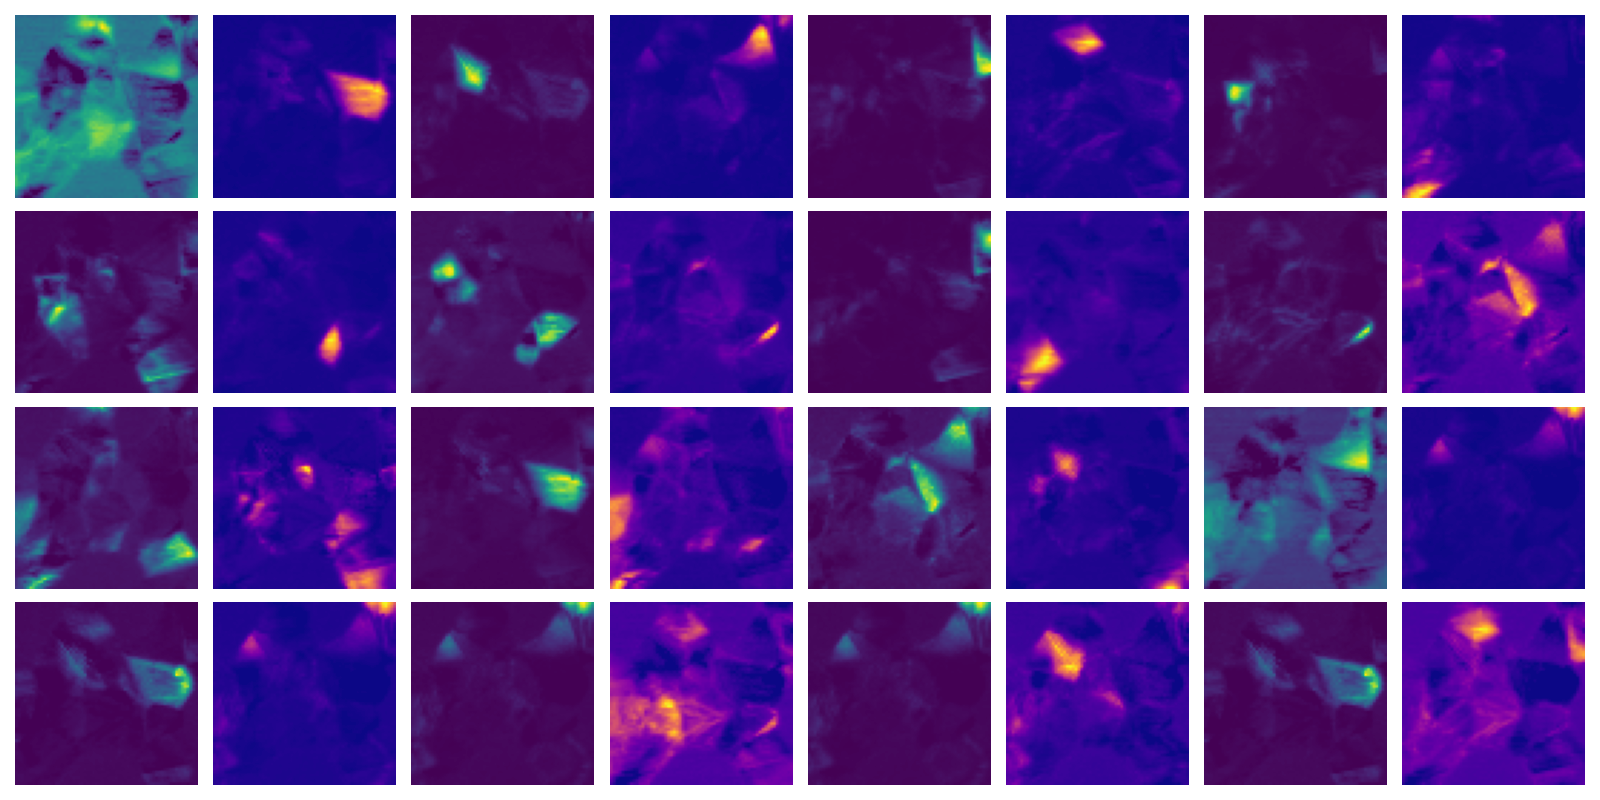

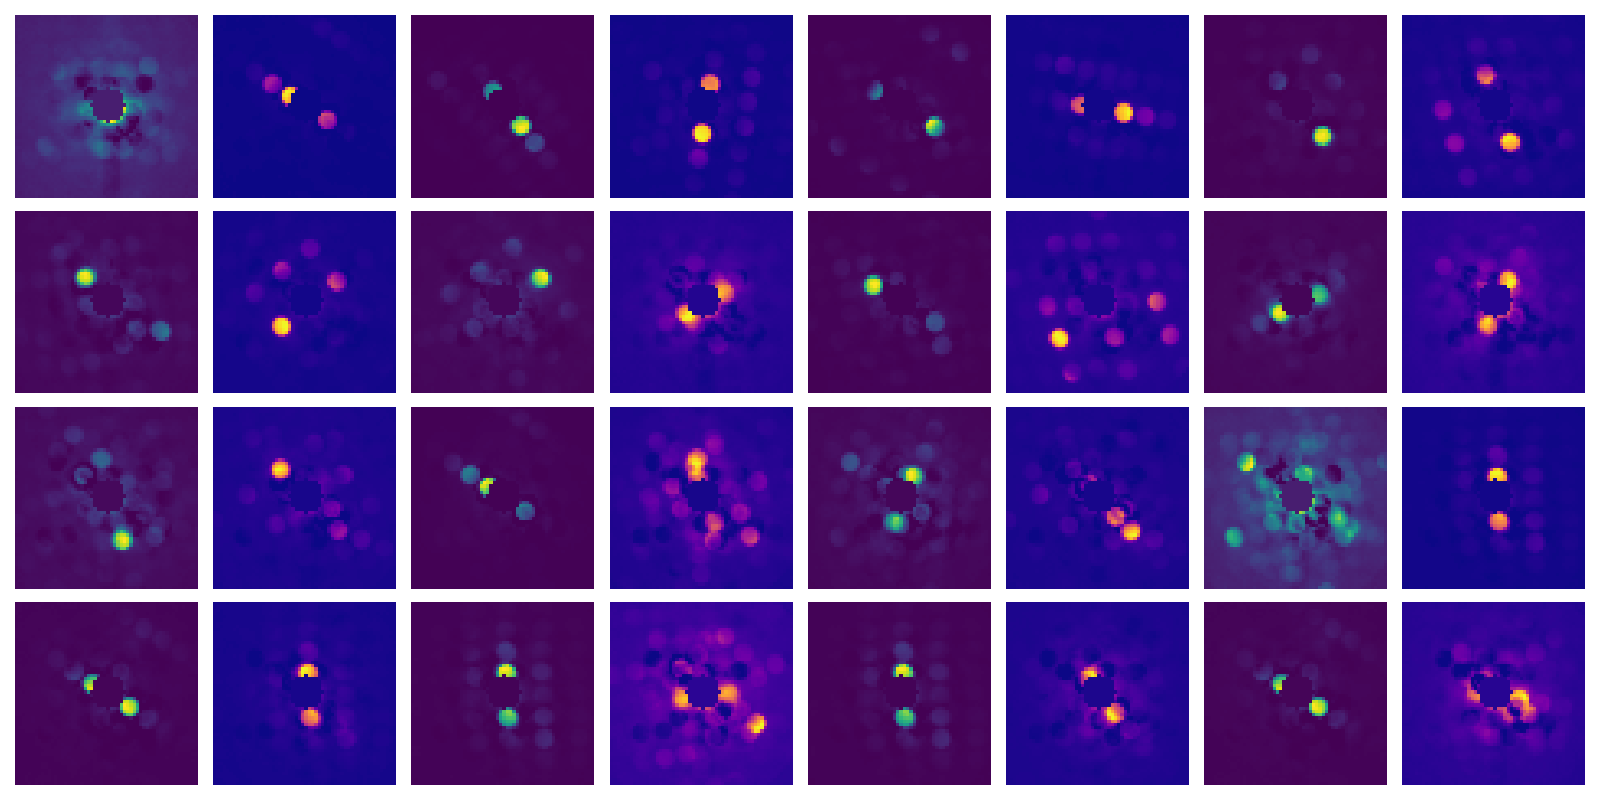

In [163]:
n_components = 32
nmf = NMF(n_components=n_components, init='nndsvd', random_state=42, max_iter=2000, alpha_W=0.0001, alpha_H=0.01)
W = nmf.fit_transform(norm_data_flat)  # shape: (num_valid_pixels, n_components)
H = nmf.components_                 # shape: (n_components, 1024)

W_reshaped = W.reshape(norm_data.shape[0], norm_data.shape[1], n_components)
H_reshaped = H.reshape(n_components, norm_data.shape[-2], norm_data.shape[-1])
print(f"Reconstruction error: {nmf.reconstruction_err_:.4f}")

# Visualize real-space activations (W)
cmaps = ['viridis', 'plasma'] * 32  # repeating pattern of colormaps
fig, ax = plt.subplots(4, 8, figsize=(16,8))
ax = ax.ravel()
for i in range(n_components):
    ax[i].imshow(image, cmap='grey')
    ax[i].imshow(W_reshaped[:, :, i], cmap=cmaps[i], origin='lower')
    ax[i].axis('off')
    # ax[i].set_title(f'Comp {i}: {np.nanmin(W_reshaped[:,:,i]):.2f}:{np.nanmax(W_reshaped[:,:,i]):.2f}')
plt.tight_layout()

# Visualize component patterns (H)
fig, ax = plt.subplots(4, 8, figsize=(16,8))
ax = ax.ravel()
for i in range(n_components):
    ax[i].imshow(H_reshaped[i], cmap=cmaps[i], origin='lower')
    ax[i].axis('off')
    # ax[i].set_title(f'Comp {i}: {H_reshaped[i].min():.2f}:{H_reshaped[i].max():.2f}')
plt.tight_layout()


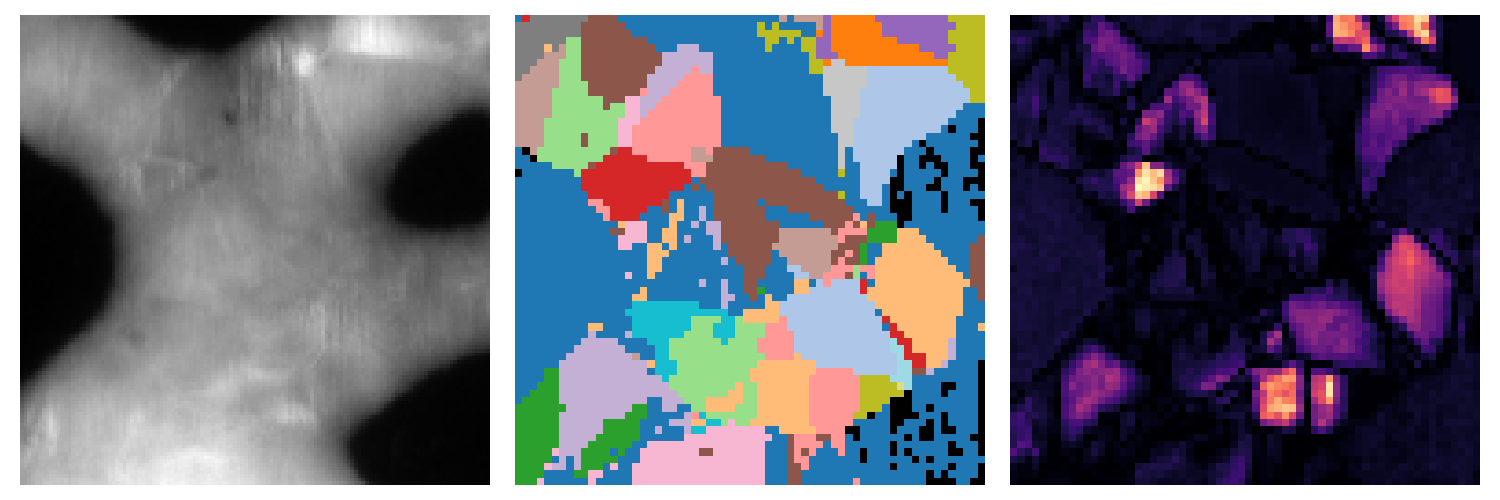

In [164]:
# --- dominant component per pixel ---
dominant = np.argmax(W_reshaped, axis=2)          # (Nx, Ny)
strength = np.max(W_reshaped, axis=2)

# optional: confidence (how dominant is the winner?)
sorted_W = np.sort(W_reshaped, axis=2)
confidence = sorted_W[:, :, -1] / (sorted_W[:, :, -2] + 1e-8)

# mask weak pixels
min_strength = 0.05 * strength.max()
grain_map = np.where(strength > min_strength, dominant, -1)

# --- colormap ---
colors = plt.cm.tab20(np.linspace(0, 1, n_components))
colors = np.vstack([[0, 0, 0, 1], colors])   # black for background
grain_cmap = ListedColormap(colors)

# shift labels by +1 for background
grain_map_plot = grain_map + 1

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(image.T, cmap='gray', origin='lower')
ax[1].imshow(grain_map_plot.T, cmap=grain_cmap, origin='lower')
ax[2].imshow(confidence.T, cmap='magma', origin='lower')

for a in ax:
    a.axis('off')
fig.tight_layout()